In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import calendar
warnings.filterwarnings('ignore')

In [2]:
months = list(calendar.month_name)[1:]

In [3]:
path = '../../data_misc/eia_form923/**/EIA923_Schedules_2_3_4_5_M_12_*_Final_Revision.xlsx'
files = glob.glob(path)
files.append('../../data_misc/eia_form923/f923_2013/EIA923_Schedules_2_3_4_5_2013_Final_Revision.xlsx')
files.append('../../data_misc/eia_form923/f923_2021/EIA923_Schedules_2_3_4_5_M_12_2021_Final.xlsx')

years = np.arange(2018,2022,1).astype('int')
files.sort()
for x, y in zip(years, files):
    print(x,y)

2018 ../../data_misc/eia_form923/f923_2012/EIA923_Schedules_2_3_4_5_M_12_2012_Final_Revision.xlsx
2019 ../../data_misc/eia_form923/f923_2013/EIA923_Schedules_2_3_4_5_2013_Final_Revision.xlsx
2020 ../../data_misc/eia_form923/f923_2014/EIA923_Schedules_2_3_4_5_M_12_2014_Final_Revision.xlsx
2021 ../../data_misc/eia_form923/f923_2015/EIA923_Schedules_2_3_4_5_M_12_2015_Final_Revision.xlsx


In [4]:
files[-4:]

['../../data_misc/eia_form923/f923_2018/EIA923_Schedules_2_3_4_5_M_12_2018_Final_Revision.xlsx',
 '../../data_misc/eia_form923/f923_2019/EIA923_Schedules_2_3_4_5_M_12_2019_Final_Revision.xlsx',
 '../../data_misc/eia_form923/f923_2020/EIA923_Schedules_2_3_4_5_M_12_2020_Final_Revision.xlsx',
 '../../data_misc/eia_form923/f923_2021/EIA923_Schedules_2_3_4_5_M_12_2021_Final.xlsx']

In [5]:
path = '../../data_misc/eia_data/emissions20*.xlsx'
efiles = glob.glob(path)

efiles.sort()
for x, y in zip(years, efiles):
    print(x,y)

2018 ../../data_misc/eia_data/emissions2018.xlsx
2019 ../../data_misc/eia_data/emissions2019.xlsx
2020 ../../data_misc/eia_data/emissions2020.xlsx
2021 ../../data_misc/eia_data/emissions2021.xlsx


# Get the generation data from EIA Form 923 for each emitting plant in NY

In [6]:
zero_emission_codes = ["SUN","GEO","OTH","HPS","HYC","NUC","ORW","WND"]

In [7]:
f = files[-1]
df = pd.read_excel(f,skiprows=5, na_values='.',
                   usecols=[0,3,6,14,15]+list(np.arange(79,91,1).astype('int')))

In [43]:
final_df = pd.DataFrame({'Month':months})
co2_rate = {}

In [47]:
for k,(i, j) in enumerate(zip(files[-4:], efiles)):
    print(k, i, j)
    f = files[-1]
    df = pd.read_excel(i,skiprows=5, na_values='.',
                       usecols=[0,3,6,14,15]+list(np.arange(79,91,1).astype('int')))
    df_ny = df[(df['Plant State']=='NY')&(df['Plant Id'] < 99999)&(~df['AER\nFuel Type Code'].isin(zero_emission_codes))]
    df_ny.groupby('Plant Name').sum().iloc[:,1:15].sum(axis=1)*1000

    # READ emissions data
    edf = pd.read_excel(j, skiprows=1)
    edf = edf[edf['Plant Code'].isin(df_ny['Plant Id'].values)].groupby('Plant Name').sum()[['Generation (kWh)',
                                                                                             'Metric Tonnes of CO2 Emissions']]
    edf['CO2 Rate (Tonne/kWh)'] = edf.iloc[:,1]/edf.iloc[:,0]

    df_ny_gen = df_ny[df_ny['Plant Name'].isin(edf.index.values)].groupby('Plant Name').sum().iloc[:,1:]
    edf_match = edf[(edf.index.isin(df_ny_gen.index.values))&(edf['Generation (kWh)']>0)]
    edf_match['CO2 Rate (Tonne/MWh)'] = edf_match['CO2 Rate (Tonne/kWh)']*1e3

    co2 = df_ny_gen.multiply(edf_match['CO2 Rate (Tonne/MWh)'],axis=0).sum(axis=0).values
    y = 2018+k
    final_df[f'{y}'] = co2
    co2_rate[f'{y}'] = edf_match['CO2 Rate (Tonne/MWh)'].sum()

0 ../../data_misc/eia_form923/f923_2018/EIA923_Schedules_2_3_4_5_M_12_2018_Final_Revision.xlsx ../../data_misc/eia_data/emissions2018.xlsx
1 ../../data_misc/eia_form923/f923_2019/EIA923_Schedules_2_3_4_5_M_12_2019_Final_Revision.xlsx ../../data_misc/eia_data/emissions2019.xlsx
2 ../../data_misc/eia_form923/f923_2020/EIA923_Schedules_2_3_4_5_M_12_2020_Final_Revision.xlsx ../../data_misc/eia_data/emissions2020.xlsx
3 ../../data_misc/eia_form923/f923_2021/EIA923_Schedules_2_3_4_5_M_12_2021_Final.xlsx ../../data_misc/eia_data/emissions2021.xlsx


In [48]:
final_df.set_index('Month',inplace=True)

In [49]:
final_df

,2021,2018,2019,2020
Month,,,,
January,2.209024e+06,2.826108e+06,2.322773e+06,1.996027e+06
February,1.885290e+06,1.556969e+06,1.862208e+06,1.874304e+06
March,1.708783e+06,1.814657e+06,1.802658e+06,1.920999e+06
April,1.385598e+06,1.710736e+06,1.476082e+06,1.369798e+06
May,1.831803e+06,1.947297e+06,1.453577e+06,1.505068e+06
June,2.691186e+06,2.284630e+06,1.954267e+06,2.419796e+06
July,2.975032e+06,3.390081e+06,3.405657e+06,3.686715e+06
August,3.302219e+06,3.528874e+06,2.884714e+06,3.241764e+06
September,2.175396e+06,2.634774e+06,1.996884e+06,2.414002e+06


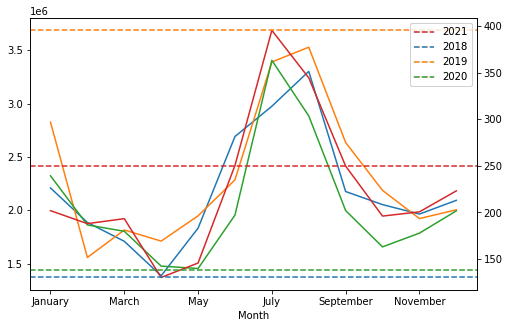

In [51]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
final_df.plot(ax=ax)
colors={2018:'tab:blue',2019:'tab:orange',2020:'tab:green',2021:'tab:red',}
# for y,v in final_df.mean(axis=0).items():
for y,v in co2_rate.items():
    ax2.axhline(y=v, label=f'{y}', linestyle='--', color=colors[int(y)])
ax.legend()
ax2.legend()